In [1]:
import pandas as pd
import wrangle
import new_wrangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model as m

import math
from sklearn.metrics import mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor 
from sklearn.model_selection import cross_val_score


# Wrangle

In [2]:
df =new_wrangle.wrangle_walmart()

In [3]:
df.head()

,store_id,this_week_date,this_week_sales,this_week_holiday_flag,temperature,fuel_price,CPI,this_week_unemployment,store_type,store_size,...,unemp_4wk_rolling,avgMoM_perc_fuel,avgMoM_perc_cpi,avgMoM_perc_unemp,fuel_quarterly_rolling,cpi_quarterly_rolling,unemp_quarterly_rolling,avgQoQ_perc_fuel,avgQoQ_perc_cpi,avgQoQ_perc_unemp
id,,,,,,,,,,,,,,,,,,,,,
2010-02-05_store_1_2010-02-12,1,2010-02-05,1643690.90,0,42,2.57,211.096,8.106,A,151315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-12_store_1_2010-02-19,1,2010-02-12,1641957.44,1,38,2.55,211.242,8.106,A,151315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-19_store_1_2010-02-26,1,2010-02-19,1611968.17,0,39,2.51,211.289,8.106,A,151315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-26_store_1_2010-03-05,1,2010-02-26,1409727.59,0,46,2.56,211.320,8.106,A,151315,...,8.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-05_store_1_2010-03-12,1,2010-03-05,1554806.68,0,46,2.62,211.350,8.106,A,151315,...,8.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# split and scale before modeling

In [4]:
train, test,  X_train_scaled, X_test_scaled, y_train, y_test = new_wrangle.split_scale(df, 'next_week_sales_target', MinMaxScaler())

train -> (2866, 32)
test -> (1229, 32)


In [5]:
X_train_scaled.shape, X_test_scaled.shape

((2866, 26), (1229, 26))

In [6]:
#features to drop before modeling due to autocorrelation:

In [7]:
col = ['this_week_unemployment', 'fuel_price', 'CPI', 'unemp_quarterly_rolling', 'fuel_quarterly_rolling', 'cpi_quarterly_rolling']

In [8]:
X_train_scaled = X_train_scaled.drop(columns = col)
X_test_scaled = X_test_scaled.drop(columns = col)

In [9]:
X_train_scaled.shape, X_test_scaled.shape

((2866, 20), (1229, 20))

# MODEL

**Note :** Before modeling, we split and scale (MinMax) our df.

For the modeling section, we established the **baseline** using  `next_week_1_year_ago`


- We use 4 different algorithms
    - Linear Regression(OLS)
    - Lasso Lars
    - TweedieRegressor (GLM)
    - Polynomial Regression

For each model we used :

 - **GridSearchCV**: grid search cross-validation (GridSearchCV) class that helps us quickly try out many different combinations of hyperparameters.
 
- **Feature Engineering:**

   - **RFE :** (recursive feature elimination)  recursively removes attributes to meet the required number of features and then builds a model on those attributes that remain.
   - **SelectKBest:** removes all but the highest scoring features.




In [10]:
# #conver y_train y_test to df  (so we can keep track of the predictions)
y_train_df = pd.DataFrame( {'actual': y_train})
y_test_df = pd.DataFrame( {'actual': y_test})

##  - BASELINE

In [11]:
#baseline version using last years sales
y_train_df['last_year_baseline'] = train['next_week_1_year_ago']

In [12]:
#calculate RMSE for baseline model
rmse_baseline2_train= math.sqrt(mean_squared_error(y_train_df.actual, y_train_df.last_year_baseline))

rmse_baseline2_train

91145.28223498359

In [13]:
#acreate a metric df to store the metrics of each model
metric_df = pd.DataFrame(data = [{
    'model': 'baseline(using last year sales)',
    'rmse_train':rmse_baseline2_train,    
    'r^2' : 0}])

## MODEL: LinearRegression (OLS)

### - Gridsearch

In [14]:
#specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {'normalize': [ True, False],
          'fit_intercept': [True, False]}

In [15]:
#use a gridsearch function using 
m.gridsearch (X_train_scaled, y_train, LinearRegression() , params, 'neg_root_mean_squared_error')

,fit_intercept,normalize,score
2,False,True,-78124.182925
3,False,False,-78124.182925
0,True,True,-70665.229164
1,True,False,-70665.229164


### OLS uising select K best (10)

In [16]:
#using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 10)

The top 10 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']


In [17]:
#create the model
ols_sb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual',\
                       LinearRegression(normalize=False,\
                        fit_intercept=True ), 'modelOLS' )
ols_sb['rmse']

72474.37897198633

#### cross validation

In [18]:
#create the model
clf = LinearRegression(normalize=True, fit_intercept=True )
#cv = number of folds
cross_val_score(clf, X_train_scaled[top_sb], y_train, cv=3, scoring = 'neg_root_mean_squared_error')

array([-72769.62947968, -73703.84102292, -73404.54496025])

### OLS uising  RFE (10)

In [19]:
#uise the fucntion to get RFE
top_rfe = m.select_rfe(X_train_scaled, y_train, 10,LinearRegression(normalize=True, fit_intercept=True ))

The top 10 selected feautures based on the the RFE class class are: ['this_week_sales', 'this_week_holiday_flag', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'unemp_4wk_rolling', 'avgMoM_perc_unemp', 'avgQoQ_perc_fuel', 'avgQoQ_perc_unemp']
this_week_sales            1
avgQoQ_perc_fuel           1
avgMoM_perc_unemp          1
unemp_4wk_rolling          1
thanksgiving               1
christmas                  1
avgQoQ_perc_unemp          1
next_week_1_year_ago       1
store_size                 1
this_week_holiday_flag     1
avgMoM_perc_cpi            2
labor_day                  3
super_bowl                 4
fuel_4wk_rolling           5
pre_christmas              6
avgMoM_perc_fuel           7
avgQoQ_perc_cpi            8
next_week_holiday_flag     9
temperature               10
cpi_4wk_rolling           11
dtype: int64


In [20]:
#create the model
ols_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual', LinearRegression(normalize=True, fit_intercept=True ), 'modelOLS' )
ols_rfe['rmse']

70339.07052044076

#### cross validation

In [21]:
#create the model
clf = LinearRegression(normalize=True, fit_intercept=True )
#cv = number of folds
cross_val_score(clf, X_train_scaled[top_rfe], y_train, cv=3, scoring = 'neg_root_mean_squared_error')

array([-70080.50217941, -71528.662538  , -71789.27133027])

**NOTE: The best OLS model is ols_rf**

In [22]:
#add the best model  metrics to our metric_df
metric_df = metric_df.append(
    {
    'model': 'ols_rfe',
    'rmse_train': ols_rfe['rmse'],    
    'r^2' : ols_rfe['r2']}, ignore_index=True)

## Model :LassoLars

### - GridsearchCV

In [23]:
#specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'normalize': [True, False],
          'fit_intercept':[True, False],
           'alpha': [1.0, 0]
         }

In [24]:
#use the function to get the combinations of parameters
m.gridsearch (X_train_scaled, y_train, LassoLars() , params, 'neg_root_mean_squared_error')

,alpha,fit_intercept,normalize,score
6,0.0,False,True,-78124.182925
7,0.0,False,False,-78124.182925
2,1.0,False,True,-78123.766036
3,1.0,False,False,-78123.766036
5,0.0,True,False,-70665.229164
4,0.0,True,True,-70665.229164
1,1.0,True,False,-70664.424471
0,1.0,True,True,-70657.415397


### LassoLars using RFE 

In [25]:
#get the 6 features
top_rfe = m.select_rfe(X_train_scaled, y_train, 6, LassoLars(alpha = 1, normalize= True, fit_intercept= True) )

The top 6 selected feautures based on the the RFE class class are: ['this_week_sales', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'avgQoQ_perc_unemp']
this_week_sales            1
thanksgiving               1
christmas                  1
next_week_1_year_ago       1
avgQoQ_perc_unemp          1
store_size                 1
unemp_4wk_rolling          2
this_week_holiday_flag     3
avgQoQ_perc_fuel           4
avgMoM_perc_unemp          5
avgMoM_perc_cpi            6
next_week_holiday_flag     7
fuel_4wk_rolling           8
avgMoM_perc_fuel           9
pre_christmas             10
labor_day                 11
avgQoQ_perc_cpi           12
cpi_4wk_rolling           13
temperature               14
super_bowl                15
dtype: int64


In [26]:
#create the model
lasso_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual', LassoLars(alpha = 1, normalize= False, fit_intercept= True), 'modelLasso' )
lasso_rfe['rmse']

71522.66640807404

### cross validation

In [27]:
#create the model
clf = LassoLars(alpha = 1, normalize= False, fit_intercept= True)
#cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_rfe], y_train, cv=3, scoring = 'neg_root_mean_squared_error')
cross

array([-71447.2057401 , -72244.57440475, -72581.69415924])

### LassoLars using selectKbest

In [28]:
#using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 9)

The top 9 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling']


In [29]:
lasso_skb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual', LassoLars(alpha = 1, normalize= True, fit_intercept= True), 'modelLasso' )
lasso_skb['rmse']

73370.09336590652

### cross validation

In [30]:
#create the model
clf = LassoLars(alpha = 1, normalize= False, fit_intercept= True)
#cv = number of folds
cross= cross_val_score(clf, X_train_scaled[top_sb], y_train, cv=3, scoring = 'neg_root_mean_squared_error')
cross

array([-74045.96153329, -74430.52250561, -74022.31451342])

**Note: the best LassoLars model is lasso_rfe**

In [31]:
#add the best model and its metrics
metric_df = metric_df.append(
    {
    'model': 'lasso_rfe',
    'rmse_train': lasso_rfe['rmse'],    
    'r^2' : lasso_rfe['r2']}, ignore_index=True)

## TweedieRegressor (GLM)

### - Gridsearch CV

In [32]:
#specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'power': [0.0, 1],
           'fit_intercept' : [True , False],
          'warm_start': [True, False], 
           'alpha': [1.0, 0.0]
         }
#use the function
m.gridsearch (X_train_scaled, y_train,TweedieRegressor() , params, 'neg_root_mean_squared_error')

,alpha,fit_intercept,power,warm_start,score
14,0.0,False,1.0,True,-1.383688e+06
15,0.0,False,1.0,False,-1.383688e+06
6,1.0,False,1.0,True,-1.383662e+06
7,1.0,False,1.0,False,-1.383662e+06
4,1.0,False,0.0,True,-5.291123e+05
5,1.0,False,0.0,False,-5.291123e+05
0,1.0,True,0.0,True,-4.964809e+05
1,1.0,True,0.0,False,-4.964809e+05
10,0.0,True,1.0,True,-1.441567e+05
11,0.0,True,1.0,False,-1.441567e+05


### create GLM using RFE

In [33]:
#use function to get the top 6 RFE
top_rfe = m.select_rfe(X_train_scaled, y_train, 7, TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False) )

The top 7 selected feautures based on the the RFE class class are: ['this_week_sales', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']
this_week_sales            1
unemp_4wk_rolling          1
thanksgiving               1
christmas                  1
avgQoQ_perc_unemp          1
store_size                 1
next_week_1_year_ago       1
this_week_holiday_flag     2
avgQoQ_perc_fuel           3
avgMoM_perc_unemp          4
avgMoM_perc_cpi            5
labor_day                  6
super_bowl                 7
fuel_4wk_rolling           8
pre_christmas              9
avgMoM_perc_fuel          10
avgQoQ_perc_cpi           11
next_week_holiday_flag    12
temperature               13
cpi_4wk_rolling           14
dtype: int64


In [34]:
#create the model
gml_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual',TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False), 'modelgml' )
gml_rfe['rmse']

71197.37052405278

#### cross validation

In [35]:
#create the model
clf = TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,warm_start= False)
#cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_rfe], y_train, scoring = 'neg_root_mean_squared_error', cv=3)
cross

array([-71374.06029116, -72012.42497728, -72054.63146727])

### create GML using select kbest

In [36]:
#using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 7)

The top 7 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'pre_christmas', 'cpi_4wk_rolling', 'unemp_4wk_rolling']


In [37]:
#create a model
gml_skb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual',TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False), 'modelgml' )
gml_skb['rmse']

74330.91020801304

#### cross validation

In [38]:
#create the model
clf = TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,warm_start= False)
#cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_sb], y_train, scoring = 'neg_root_mean_squared_error',cv=3)
cross

array([-75377.89622107, -73349.13363488, -75559.29396566])

**Note the best model for GLM is gml_rfe**

In [39]:
#add the best model
metric_df = metric_df.append(
    {
    'model': 'gml_rfe',
    'rmse_train': gml_rfe['rmse'],    
    'r^2' : gml_rfe['r2']}, ignore_index=True)

# Polynomial Regression

###  - Polynomila Regression using select k best 

In [40]:
#using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 10)

The top 10 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']


In [41]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2) 

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[top_sb])

# transform X_validate_scaled & X_test_scaled
X_test_degree3 = pf.transform(X_test_scaled[top_sb])

### GridSearchCV

In [42]:
#specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'normalize': [True, False],
          'fit_intercept':[True, False],
         }

m.gridsearch (X_train_degree3, y_train, LinearRegression() , params, 'neg_root_mean_squared_error')

,fit_intercept,normalize,score
1,True,False,-68537.823324
0,True,True,-67663.495945
2,False,True,-67280.147803
3,False,False,-67280.147803


In [43]:
#create a model
pol_skb = m.create_model(X_train_degree3, y_train_df, 'actual',LinearRegression( normalize=True, fit_intercept = True ), 'pol2_skb' )
pol_skb['rmse']

64609.20374104813

##### cross validation

In [44]:
#create the model
clf = LinearRegression( normalize=False, fit_intercept = True )
#cv = number of folds
cross = cross_val_score(clf, X_train_degree3, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
cross

array([-66016.67167466, -67841.00338362, -70257.44391932, -67202.36159337,
       -71371.636051  ])

In [45]:
metric_df = metric_df.append(
    {
    'model': 'pol2_skb',
    'rmse_train': pol_skb['rmse'],    
    'r^2' : pol_skb['r2']}, ignore_index=True)

### -Polynoliam regression using RFE

In [46]:
#get the top 7 features by RFE
top_rfe_pol = m.select_rfe(X_train_scaled, y_train, 11, LinearRegression(normalize=False, fit_intercept = False) )

The top 11 selected feautures based on the the RFE class class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'christmas', 'pre_christmas', 'super_bowl', 'thanksgiving', 'avgMoM_perc_cpi', 'avgMoM_perc_unemp', 'avgQoQ_perc_unemp']
this_week_sales            1
avgMoM_perc_unemp          1
avgMoM_perc_cpi            1
thanksgiving               1
pre_christmas              1
christmas                  1
super_bowl                 1
next_week_1_year_ago       1
store_size                 1
temperature                1
avgQoQ_perc_unemp          1
avgQoQ_perc_fuel           2
this_week_holiday_flag     3
avgQoQ_perc_cpi            4
unemp_4wk_rolling          5
avgMoM_perc_fuel           6
cpi_4wk_rolling            7
next_week_holiday_flag     8
labor_day                  9
fuel_4wk_rolling          10
dtype: int64


In [47]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2) 

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[top_rfe_pol])

# transform X_validate_scaled & X_test_scaled
X_test_degree3 = pf.transform(X_test_scaled[top_rfe_pol])

#### GridsearchCV

In [48]:
m.gridsearch (X_train_degree3, y_train, LinearRegression() , params, 'neg_root_mean_squared_error')

,fit_intercept,normalize,score
0,True,True,-66226.573280
1,True,False,-66187.084301
2,False,True,-66187.084301
3,False,False,-66187.084301


In [49]:
#create the model
pol_rfe = m.create_model(X_train_degree3, y_train_df, 'actual',LinearRegression( normalize=False, fit_intercept = False ), 'pol3_RFE' )
pol_rfe['rmse']

63537.88275172522

#### cross validation

In [50]:
#create the model
clf = LinearRegression( normalize=False, fit_intercept = False )
#cv = number of folds
cross = cross_val_score(clf, X_train_degree3, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
cross

array([-62337.00446424, -65569.35237058, -68225.96990924, -66758.2633866 ,
       -68044.83137326])

In [51]:
metric_df = metric_df.append(
    {
    'model': 'pol2_rfe',
    'rmse_train': pol_rfe['rmse'],    
    'r^2' : pol_rfe['r2']}, ignore_index=True)

### -Polynomial Regression Degree 1  with all features

In [52]:
# make the polynomial features to get a new set of features using the entire df
pf = PolynomialFeatures(degree = 1) 

# fit and transform X_train_scaled
X_train_degree1 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_test_degree1 = pf.transform(X_test_scaled)

### GreidSearch CV

In [53]:
m.gridsearch (X_train_degree1, y_train, LinearRegression() , params, 'neg_root_mean_squared_error')

,fit_intercept,normalize,score
2,False,True,-70665.229164
3,False,False,-70665.229164
0,True,True,-70665.229164
1,True,False,-70665.229164


In [54]:
pol_dg1 = m.create_model(X_train_degree1, y_train_df, 'actual',LinearRegression( normalize=False, fit_intercept = True ), 'modelpol' )
pol_dg1['rmse']

70077.52211783333

### Cross Validation

In [55]:
#create the model
clf = LinearRegression( normalize=False, fit_intercept = True )
#cv = number of folds
cross = cross_val_score(clf, X_train_degree1, y_train, cv=3, scoring = 'neg_root_mean_squared_error')
cross

array([-69760.12765581, -71425.17819823, -71893.93591105])

In [56]:
#add this model metrics to df
metric_df = metric_df.append(
    {
    'model': 'pol_dg1',
    'rmse_train': pol_dg1['rmse'],    
    'r^2' : pol_dg1['r2']}, ignore_index=True)

## RESULTS

In [57]:
metric_df.sort_values('rmse_train')

,model,rmse_train,r^2
5,pol2_rfe,63537.882752,0.987056
4,pol2_skb,64609.203741,0.987856
6,pol_dg1,70077.522118,0.984254
1,ols_rfe,70339.070520,0.984137
3,gml_rfe,71197.370524,0.983747
2,lasso_rfe,71522.666408,0.983573
0,baseline(using last year sales),91145.282235,0.000000


In [58]:
print('The best model is' )
metric_df.nsmallest(1, 'rmse_train')

The best model is


,model,rmse_train,r^2
5,pol2_rfe,63537.882752,0.987056


In [87]:
final = metric_df[['model', 'rmse_train']].drop(axis=0, labels= [4,6,0])
final

,model,rmse_train
1,ols_rfe,70339.070520
2,lasso_rfe,71522.666408
3,gml_rfe,71197.370524
5,pol2_rfe,63537.882752


In [102]:
new_names = ['LinearRegression(OLS)', 'LassoLars', 'TweedieRegressor', 'Polynomial Regression']

In [103]:
final.model = new_names

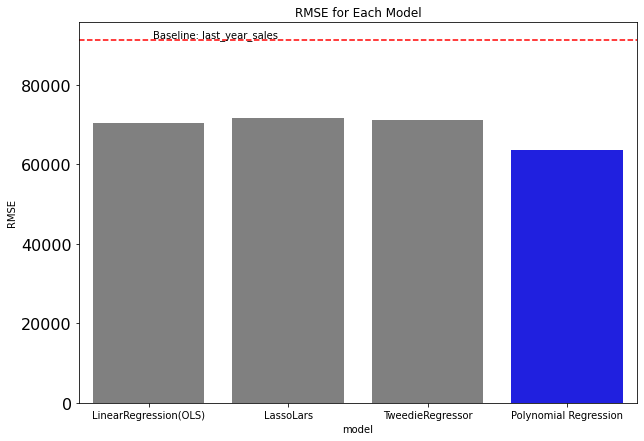

In [104]:
plt.figure(figsize=(10,7))

clrs = ['grey' if (x > min(final.rmse_train)) else 'blue' for x in final.rmse_train ]
sns.barplot(x='model', y = 'rmse_train',palette=clrs,  data = final, hue_order='pol_rfe')
plt.ylabel('')
plt.yticks(size=16)
#plt.xticks(rotation=45)
plt.axhline(rmse_baseline2_train, ls='--', color='red')
plt.annotate("Baseline: last_year_sales", (0.03, 92000))
plt.ylabel('RMSE')
plt.title("RMSE for Each Model")

plt.show()

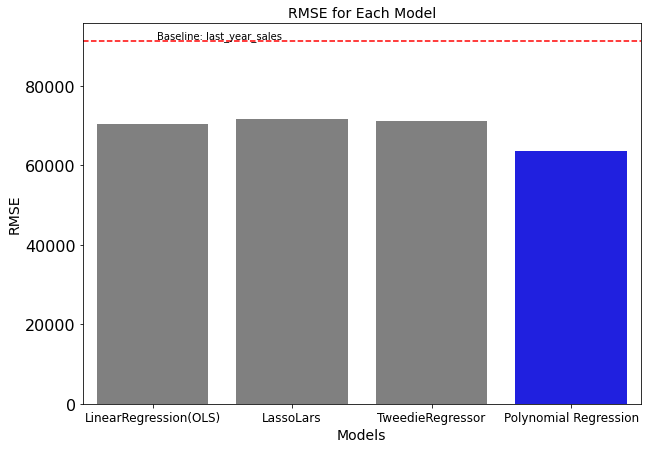

In [112]:
plt.figure(figsize=(10,7))


sns.barplot(x='model', y = 'rmse_train',palette=clrs,  data = final, hue_order='pol_rfe')
plt.xlabel('Models', fontdict={'fontsize': 14})
plt.yticks(size=16)
plt.xticks(size=12)
#plt.xticks(rotation=45)
plt.axhline(rmse_baseline2_train, ls='--', color='red')
plt.annotate("Baseline: last_year_sales", (0.03, 92000))
plt.ylabel('RMSE', fontdict={'fontsize': 14})
plt.title("RMSE for Each Model", fontdict={'fontsize': 14})

plt.show()

**Takeaways**

the best model is Polynomial Regression Degree 2 using RFE top 11 Features


In [62]:
top_rfe_pol

['this_week_sales',
 'temperature',
 'store_size',
 'next_week_1_year_ago',
 'christmas',
 'pre_christmas',
 'super_bowl',
 'thanksgiving',
 'avgMoM_perc_cpi',
 'avgMoM_perc_unemp',
 'avgQoQ_perc_unemp']

# TEST

In [63]:
#use my function to create and calculate the metrics
pol_reg_test =  m.create_model(X_test_degree3, 
                              y_test_df, 'actual',LinearRegression( normalize=False, fit_intercept = True ), 'test_polreg' )

pol_reg_test['rmse']

64607.17186826456

In [64]:
print('The Baseline RMSE is $', round(rmse_baseline2_train,2))
print('The Best Model RMSE on unseen data is $', round(pol_reg_test['rmse'],2))

The Baseline RMSE is $ 91145.28
The Best Model RMSE on unseen data is $ 64607.17


In [65]:
# it is a 29% drop
(pol_reg_test['rmse'] / rmse_baseline2_train -1)*100

-29.116274277697187

# END

___________________________________

In [66]:
y_train_df.head(1)

,actual,last_year_baseline,modelOLS,modelLasso,modelgml,pol2_skb,pol3_RFE,modelpol
id,,,,,,,,
2011-09-16_store_12_2011-09-23,871692.74,851919.34,860852.288005,839547.706159,839310.371055,862064.863244,872133.156142,858136.80876


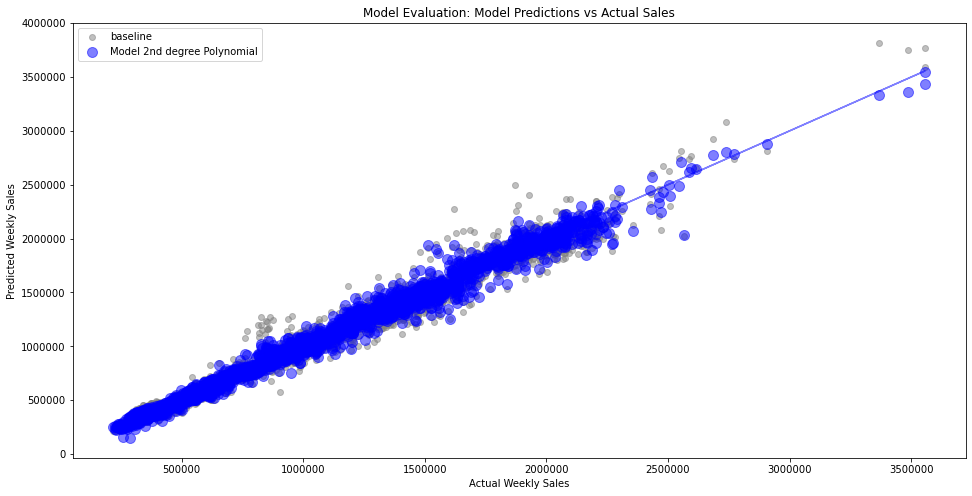

In [67]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.scatter(y_train_df.actual, y_train_df.last_year_baseline, alpha=.5, color="gray", label='baseline')
plt.annotate("Baseline: last_year_", (16, 9.5))
plt.plot(y_train_df.actual, y_train_df.actual, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

# plt.scatter(y_train_df.actual, y_train_df.modelOLS, 
#             alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_train_df.actual, y_train_df.modelLasso, 
#            alpha=.5, color="yellow", s=100, label="Model: LASSO LARS")
plt.scatter(y_train_df.actual, y_train_df.pol3_RFE, 
            alpha=.5, color="blue", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Model Evaluation: Model Predictions vs Actual Sales")
#plt.xticks(rotation=45)
plt.ticklabel_format(style = 'plain')
plt.show()

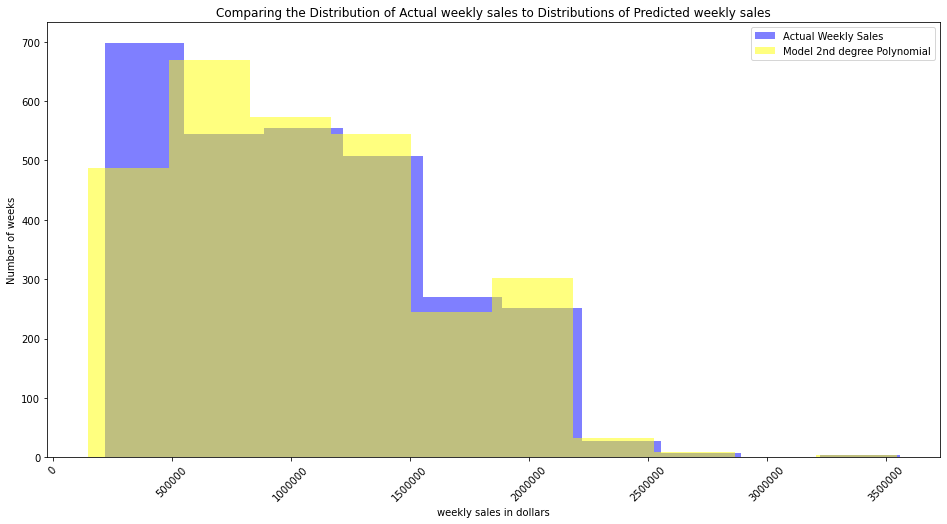

In [68]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_train_df.actual, color='blue', alpha=.5, label="Actual Weekly Sales")
# plt.hist(y_train_df.modelOLS, color='red', alpha=.5, label="Model: LinearRegression")
# plt.hist(y_train_df.modelLasso, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_train_df.pol3_RFE, color='yellow', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("weekly sales in dollars")
plt.ylabel("Number of weeks")
plt.title("Comparing the Distribution of Actual weekly sales to Distributions of Predicted weekly sales")
plt.legend()
plt.xticks(rotation=45)
plt.ticklabel_format(style = 'plain')
plt.show()

In [69]:
# we need a prediction df

In [70]:
y_test_df.head(15)

,actual,test_polreg
id,,
2011-03-18_store_7_2011-03-25,559061.58,5.527137e+05
2012-10-19_store_41_2012-10-26,1316542.59,1.335390e+06
2012-02-17_store_36_2012-02-24,313270.45,3.505920e+05
2012-03-16_store_26_2012-03-23,874790.68,8.858348e+05
2012-03-02_store_43_2012-03-09,636677.67,6.678347e+05
2012-02-03_store_42_2012-02-10,674919.45,6.555945e+05
2011-11-25_store_41_2011-12-02,1292436.23,1.276042e+06
2012-02-17_store_23_2012-02-24,1272948.27,1.239638e+06
2011-04-08_store_23_2011-04-15,1263680.51,1.301305e+06


In [71]:
y_test_df.shape

(1229, 2)

In [72]:
df[['this_week_date', 'next_week_date']].head()

,this_week_date,next_week_date
id,,
2010-02-05_store_1_2010-02-12,2010-02-05,2010-02-12
2010-02-12_store_1_2010-02-19,2010-02-12,2010-02-19
2010-02-19_store_1_2010-02-26,2010-02-19,2010-02-26
2010-02-26_store_1_2010-03-05,2010-02-26,2010-03-05
2010-03-05_store_1_2010-03-12,2010-03-05,2010-03-12


In [73]:
pred_df = y_test_df.merge(df[['this_week_date', 'next_week_date']], how = 'left', on = 'id')

In [74]:
pred_df.to_csv('pred_df.csv')

In [75]:
# y_train_df[['actual','pol3_RFE']].head()

In [76]:
# Best model
pf = PolynomialFeatures(degree = 2)
pf.fit_transform(X_train_scaled[top_rfe_pol])
mod =LinearRegression( normalize=False, fit_intercept = False )
mod.fit(X_train_degree3, y_train_df['actual'])
X_train_top = X_train_scaled[top_rfe_pol]


In [77]:
#create a df
feature_importances = pd.DataFrame(mod.coef_, 
                                   index = pf.get_feature_names(X_train_top.columns), 
                                   columns=['importance']).sort_values('importance', ascending=False)

#reset index
feature_importances = feature_importances.reset_index().rename( columns ={'index': 'features'} )

# want to stat at 1 instead of 0
feature_importances.index = feature_importances.index + 1

In [78]:
feature_importances.head(10)

,features,importance
1,this_week_sales next_week_1_year_ago,7.896507e+06
2,next_week_1_year_ago,3.347676e+06
3,this_week_sales christmas,2.008084e+06
4,next_week_1_year_ago pre_christmas,1.536185e+06
5,next_week_1_year_ago thanksgiving,1.205772e+06
6,this_week_sales avgMoM_perc_cpi,1.047254e+06
7,this_week_sales,8.391197e+05
8,this_week_sales super_bowl,7.275929e+05
9,thanksgiving avgMoM_perc_unemp,5.712164e+05
10,super_bowl avgMoM_perc_unemp,4.847906e+05


In [79]:
feature_importances.tail(5)

,features,importance
74,next_week_1_year_ago avgMoM_perc_cpi,-1.130399e+06
75,this_week_sales pre_christmas,-1.361242e+06
76,next_week_1_year_ago christmas,-1.818312e+06
77,next_week_1_year_ago^2,-3.912338e+06
78,this_week_sales^2,-4.360501e+06


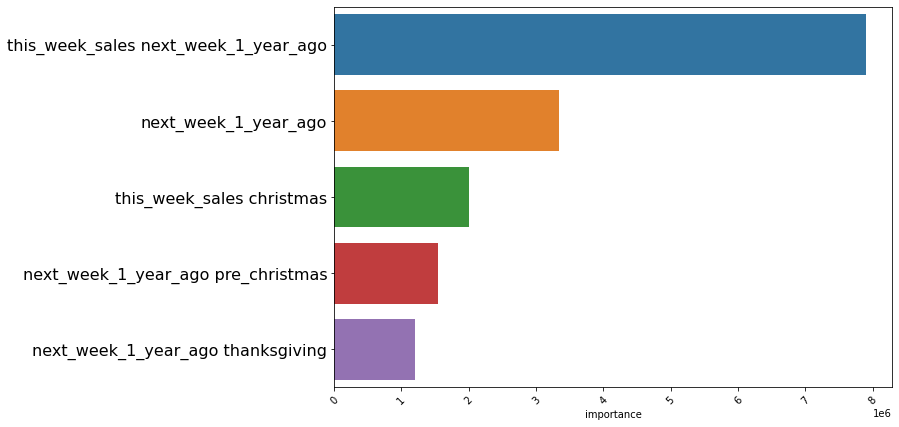

In [80]:
plt.figure(figsize=(10,7))

sns.barplot(x='importance', y = 'features', data = feature_importances.head(5))
plt.ylabel('')
plt.yticks(size=16)
plt.xticks(rotation=45)
#plt.ticklabel_format(style = 'plain')

plt.show()


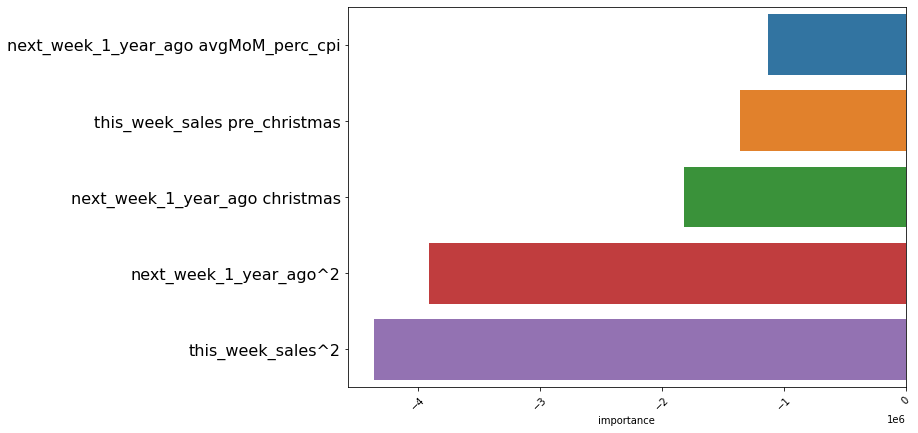

In [81]:
plt.figure(figsize=(10,7))

sns.barplot(x='importance', y = 'features', data = feature_importances.tail(5))
plt.ylabel('')
plt.yticks(size=16)
plt.xticks(rotation=45)
#plt.ticklabel_format(style = 'plain')

plt.show()

In [82]:
 df_all =pd.concat([feature_importances.head(5), feature_importances.tail(5)])

In [83]:
df_all.to_csv("pol_features.csv")


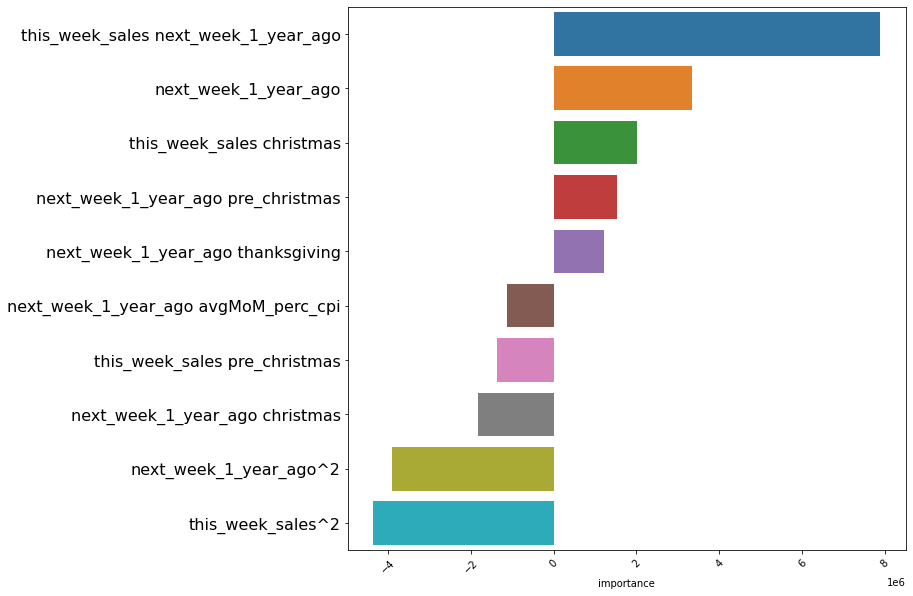

In [84]:
plt.figure(figsize=(10,10))

sns.barplot(x='importance', y = 'features', data = df_all)
plt.ylabel('')
plt.yticks(size=16)
plt.xticks(rotation=45)
#plt.ticklabel_format(style = 'plain')

plt.show()

In [85]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [86]:
from sklearn.feature_extraction import DictVectorizer
